In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from feature_calculator import FeatureCalculator


NameError: name 'data_mel' is not defined

In [2]:
###Funciones###  ### la idea es después pasar todo esto a una clase que pueda procesar los datos

import re 
from matplotlib.colors import to_rgb, to_rgba
def bp2n(x):
    if x == 'Upright':
        return 4
    elif x == 'Supine':
        return 3
    elif x == 'Prone':
        return 2
    elif x == 'Unkonwn':
        return -1
    elif x == 'Side':
        return 1
    else:
        return 0

def bp2n_(x):
    if x == 'Upright':
        return 1
    elif x == 'Supine':
        return 0
    elif x == 'Prone':
        return 0
    elif x == 'Unkonwn':
        return 0
    elif x == 'Side':
        return 0
    else:
        return 0

def date2number(x):
    #print(x)
    l = re.split('/|-| |:', x)
    #print(l)
    day = l[2]
    hour = l[3]
    minute = l[4]
    second = l[5]


    
    div = 3600
    

    taim =  float(day)*24*3600 + float(hour) * 3600 +  float(minute) * 60 +  float(second)
    #new_taim = taim - desfase_12 
    #taim = new_taim
    taim = taim/div
    #hora = float(hour)
    return taim

def neo4jdate2number(neo4jdate_object):
    n = neo4jdate_object
    
    div = 3600
    

    taim =  float(n.day)*24*3600 + float(n.hour) * 3600 +  float(n.minute) * 60 +  float(n.second)
    #new_taim = taim - desfase_12 
    #taim = new_taim
    taim = taim/div
    return taim


def take_hour(x):
    l = re.split('/|-| |:', x)
    hour = float(l[3])
    minute = float(l[4])
    second = float(l[5])

    taim = hour + minute/60 + second/3600
    return taim
def mel_hora(x):
    if x!= None:
        hora, minutos = tuple(x.split(':'))
        return float(hora) + float(minutos)/60
    else:
        return x

def plot_2(t, h, data1, data2, nombre1, nombre2, time_mel, data_mel, data_mel_2, awake):
    #cond = df['DIA.HORA'].between(48, 75, inclusive = True)
    #cond = df[cond1]['DIA.HORA'] >= 45
    
    
    time = t - (t.iloc[0] - h.iloc[0])

    fig, axs = plt.subplots(2, 2, figsize = (16, 6))

    #t = df[cond]['DIA.HORA']
    #data_dia = df[cond]['DIA']
    #data_hr = df[cond]['HR']
    #data_br = df[cond]['BR']

    ax1 = axs[0,0]
    plot_by_ax(ax1, time, data1, data2, nombre1, nombre2, time_mel, data_mel,data_mel_2, awake)
    fig.tight_layout() 
    plt.show()

def plot_by_ax(ax, time, data1, data2, nombre1, nombre2, time_mel, data_mel, data_mel_2, awake):    
    ax1 = ax
    color = 'tab:red'
    ax1.set_xlabel('time (h)')
    ax1.set_ylabel(nombre1, color=color)
    ax1.plot(time, data1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    #ax3 = ax1.twinx()

    color = 'tab:blue'
    ax2.set_ylabel(nombre2, color=color)  # we already handled the x-label with ax1
    ax2.plot(time, data2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    
    plt.axvline(x = 12, color = 'b', ls = '--',  alpha = 0.3)
    plt.axvline(x = 24, color = 'b', ls = '--',  alpha = 0.3)
    plt.axvline(x = 36, color = 'b', ls = '--',  alpha = 0.3)
    plt.axvline(x = 48, color = 'b', ls = '--',  alpha = 0.3)

    plt.axvline(x = data_mel_2, color = 'g', ls = '-')
    ''' por si se ocupa data_mel
    r, g, b = to_rgb('green')
    # r, g, b, _ = to_rgba(color)
    arr = data_mel/max(data_mel)
    color = [(r, g, b, alpha) for alpha in arr]

    plt.scatter(time_mel, np.zeros(time_mel.shape),c = color, s = 100)
    '''
    r, g, b = to_rgb('green')
    # r, g, b, _ = to_rgba(color)
    arr = awake
    color = [(r, alpha * g, b, 1) for alpha in arr]

    plt.scatter(time, np.zeros(time.shape),c = color, s = 10)    





    #color = 'tab:green'
    #ax2.set_ylabel('BR', color=color)  # we already handled the x-label with ax1
    #ax2.plot(t, data_br, color=color)
    #ax2.tick_params(axis='y', labelcolor=color)


In [123]:
paciente = 16
df = pd.read_csv(f'datos/Datos0{paciente}.csv', encoding='latin-1')
df = df.drop(['Unnamed: 0'], axis=1)
df = df.interpolate(method = 'linear', axis = 0)



#plt.plot(df['DIA'])
#plt.plot(df['HR'])
#plt.show()
#plt.plot()
df['Body.position'] = df['Body.position'].apply(bp2n_) 
df['Dream.Status.subject'] = df['Dream.Status.subject'].apply(lambda x: 1 if x == 'Awake' else 0)

horas_ = df['DIA.HORA'].apply(take_hour)
df['DIA.HORA'] = df['DIA.HORA'].apply(date2number)
tiempo_0 = df['DIA.HORA'].iloc[0]
df['DIA.HORA'] = df['DIA.HORA'] - tiempo_0


##### Obtenemos los datos de melatonina (que serán ploteados como lineas)
calculator = FeatureCalculator("neo4j://quantitativephysiology.ing.puc.cl:6087", "user", "password", "chronotype")
mel = ["MEL", "salivette"]
data_mel = calculator.get_lf_feature_data(*mel)
data_mel = data_mel.reset_index()
data_mel = data_mel[data_mel['participant'] == paciente]
data_mel['timestamp'] = data_mel['timestamp'].apply(neo4jdate2number)
data_mel['timestamp'] = data_mel['timestamp'] - tiempo_0


#Vamos a intentar poner la melatonina en otro tiempo, para que calce con las mediciones de presión
data_mel['timestamp'] = data_mel['timestamp']%24 + 12


datos_melatonina = {1:'21:05'	,2:'0:49',	3:'22:09',	4:'22:23',	5:'0:42',	6:None,	7:'23:02',	8:'21:13',	9:'22:19',10:None, 		11:'20:43',	12:None	,13:None,	14:None,	15:'22:34',	16:'23:07',17:None,18:'23:36', 19:None}
datos_melatonina = {key: mel_hora(value) for (key, value) in datos_melatonina.items()}



In [8]:
df.keys()

Index(['DIA.HORA', 'HR', 'BR', 'Temperatura.piel', 'Temperatura.interna',
       'Body.position', 'Estado.de.movimiento', 'Zangle', 'VM', 'sdVM', 'VMC',
       'VMCn', 'ENMO', 'AIabs', 'AIrel', 'Activity count',
       'PAEE (KCals/kg/min)', 'PAEE (KCals)', 'luz', 'Sys', 'DIA',
       'HR pressure', 'Mean arterial pressure', 'Day', 'Dream.Status.Watch',
       'Dream.Status.subject'],
      dtype='object')

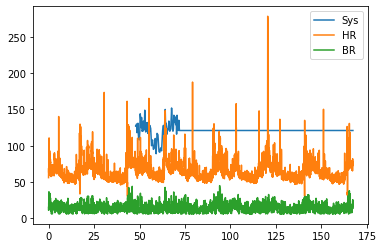

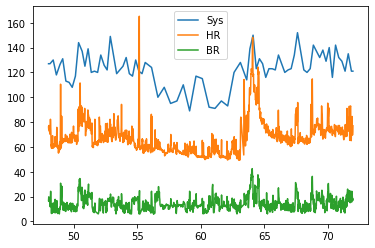

23.116666666666667
[1 1 1 ... 1 1 1]


c:\Users\rafae\AppData\Local\Programs\Python\Python37\lib\site-packages\mpld3\mplexporter\exporter.py:84: UserWarning: Blended transforms not yet supported. Zoom behavior may not work as expected.
  warnings.warn("Blended transforms not yet supported. "


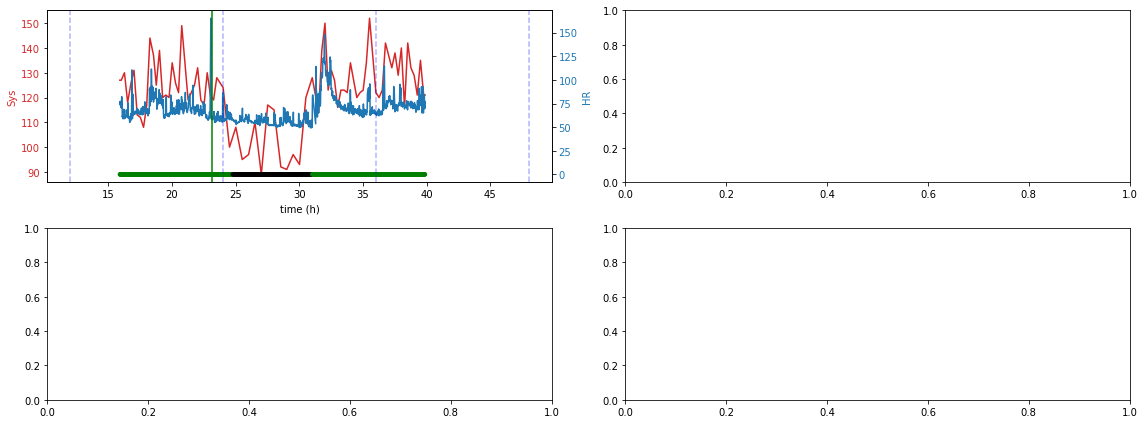

In [124]:
#Vamos a clasificar las columnas:

## actividad_externa: Estado.de.movimiento, 'VM', 'VMC', 'VMCn', 'Activity count', Body.position, para el analisis general usaremos BP y VMC
## actividad_interna: HR, BR. Para el analisis general se usaran ambos
## calorias: PAEE (KCals/kg/min), PAEE (KCals)
## Temperatura: Temperatura.piel, Temperatura.interna
## Presión: Mean arterial pressure, DIA, Sys
## Info circadiana: luz, Dat, Dream.Status.Watch, Dream.Status.subject


#Notas Avance 6:

## Hacer un ploteo con presión e indicadores de actividad externa (VMC, Activity count, Body.position) y de actividad interna
## Luego seleccionar la ventana de tiempo en la que 'calzan' ambas mediciones
## Plotear la correlación en un gráfico 
## Armar matrices de covarianza/ o de correlación

## Presión vs actividad_interna



plt.plot(df['DIA.HORA'], df['Sys'], label = 'Sys')
plt.plot(df['DIA.HORA'], df['HR'], label = 'HR')
plt.plot(df['DIA.HORA'], df['BR'], label = 'BR')
plt.legend()
plt.show()



intervalos = {'1':0, '2':(70, 100), '3':(20, 55),'4':0,'5':(68, 100),'6':(60, 90),'7':0,'8':(110, 145),'9':(70, 100),'10':0,'11':0,'12':(60, 100), '13':(15, 50), '14':(60, 100) ,'15':(60, 100), '16': (48, 72) , '17': (70, 100)}
cond = df['DIA.HORA'].between(intervalos[str(paciente)][0], intervalos[str(paciente)][1], inclusive = True)    
plt.plot(df[cond]['DIA.HORA'], df[cond]['Sys'], label = 'Sys')
plt.plot(df[cond]['DIA.HORA'], df[cond]['HR'], label = 'HR')
plt.plot(df[cond]['DIA.HORA'], df[cond]['BR'], label = 'BR')

plt.legend()
plt.show()
## En base a los plots, se dejará como intervalo, un total de 75 horas (casi 3 días)

print(datos_melatonina[paciente])    
print(df[cond]['Dream.Status.subject'].to_numpy())
plot_2(df[cond]['DIA.HORA'],horas_[cond],   df[cond]['Sys'], df[cond]['HR'], 'Sys', 'HR', data_mel['timestamp'], data_mel['MEL'], datos_melatonina[paciente], df[cond]['Dream.Status.subject'].to_numpy())
#plt.plot(data_mel['timestamp'], data_mel['MEL'], label = 'MEL')



c:\Users\rafae\AppData\Local\Programs\Python\Python37\lib\site-packages\mpld3\mplexporter\exporter.py:84: UserWarning: Blended transforms not yet supported. Zoom behavior may not work as expected.
  warnings.warn("Blended transforms not yet supported. "


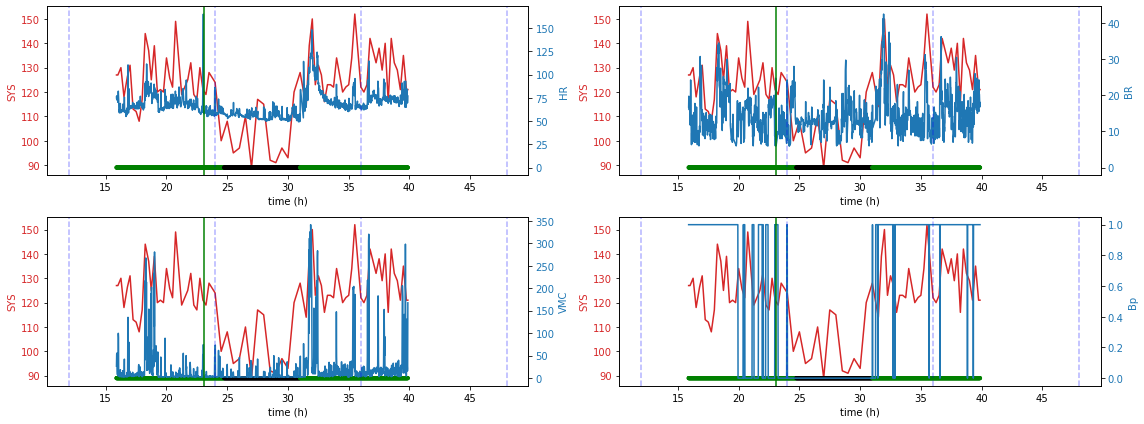

In [125]:
def plot_2_list(t, h, data1, data2, nombre1, nombre2, time_mel, data_mel, data_mel_2, awake):
    #cond = df['DIA.HORA'].between(48, 75, inclusive = True)
    #cond = df[cond1]['DIA.HORA'] >= 45
    
    
    time = t - (t.iloc[0] - h.iloc[0])

    fig, axs = plt.subplots(2, 2, figsize = (16, 6))

    #t = df[cond]['DIA.HORA']
    #data_dia = df[cond]['DIA']
    #data_hr = df[cond]['HR']
    #data_br = df[cond]['BR']
    axs = axs.flatten()
    for i in range(4):
        plot_by_ax(axs[i], time, data1, data2[i], nombre1, nombre2[i], time_mel, data_mel, data_mel_2, awake)
    fig.tight_layout() 
    plt.show()

t = df[cond]['DIA.HORA']
h = horas_[cond]
data1 = df[cond]['Sys']
#data2 = [df[cond]['HR'], df[cond]['BR'], df[cond]['VMC'].diff().apply(lambda x: x if x>50 else 0), (df[cond]['Body.position'].rolling(60).sum()).diff(periods = 50).abs().apply(lambda x: x if x>10 else 0)]
data2 = [df[cond]['HR'], df[cond]['BR'], df[cond]['VMC'], df[cond]['Body.position']]
nombre1 = 'SYS'
#nombre2 = ['HR', 'BR', 'dVMC/dt', 'dBp/dt']
nombre2 = ['HR', 'BR', 'VMC', 'Bp']




plot_2_list(t, h, data1, data2, nombre1, nombre2, data_mel['timestamp'], data_mel['MEL'], datos_melatonina[paciente], df[cond]['Dream.Status.subject'].to_numpy())

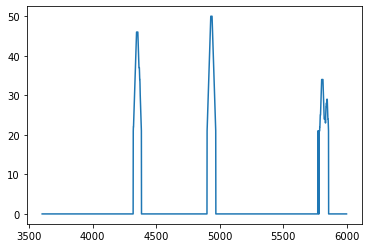

In [124]:
#plt.plot(df[cond]['VMC'])
plt.plot((df[cond]['Body.position'].rolling(60).sum()).diff(periods = 50).abs().apply(lambda x: x if x>20 else 0))

rho,  p-value
(0.559840096958192, 2.7001964370252653e-134)


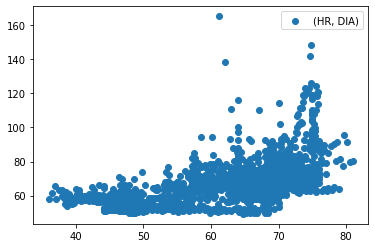

rho,  p-value
(0.22283983419666306, 1.1205011078298224e-19)


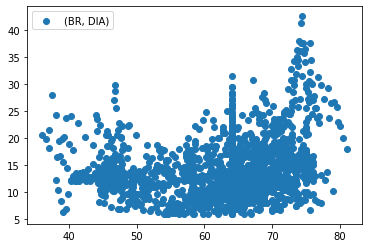

In [26]:
## Correlación
from scipy.stats import pearsonr as rho
print('rho, ', 'p-value')
print(rho(df[cond]['DIA'], df[cond]['HR']))
plt.scatter(df[cond]['DIA'], df[cond]['HR'], label = '(HR, DIA)')
plt.legend()
plt.show()

print('rho, ', 'p-value')
print(rho(df[cond]['DIA'], df[cond]['BR']))
plt.scatter(df[cond]['DIA'], df[cond]['BR'], label = '(BR, DIA)')
plt.legend()
plt.show()


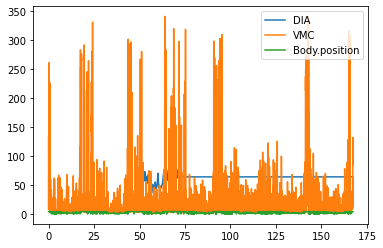

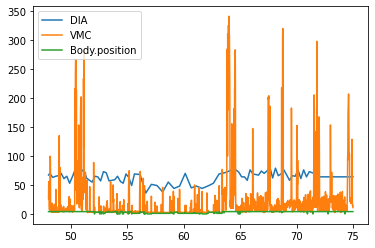

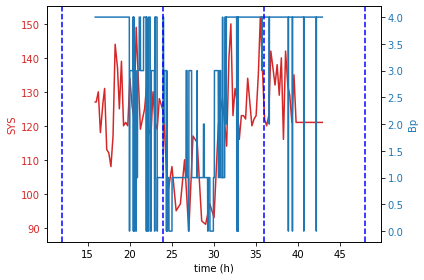

In [61]:
## Presión vs actividad_externa



plt.plot(df['DIA.HORA'], df['DIA'], label = 'DIA')
plt.plot(df['DIA.HORA'], df['VMC'], label = 'VMC')
plt.plot(df['DIA.HORA'], df['Body.position'], label = 'Body.position')
plt.legend()
plt.show()

cond = df['DIA.HORA'].between(48, 75, inclusive = True)

plt.plot(df[cond]['DIA.HORA'], df[cond]['DIA'], label = 'DIA')
plt.plot(df[cond]['DIA.HORA'], df[cond]['VMC'], label = 'VMC')
plt.plot(df[cond]['DIA.HORA'], df[cond]['Body.position'], label = 'Body.position')
plt.legend()
plt.show()
## En base a los plots, se dejará como intervalo, un total de 75 horas (casi 3 días)

plot_2(df[cond]['DIA.HORA'],horas_[cond], df[cond]['Sys'], df[cond]['Body.position'], 'SYS', 'Bp')




rho,  p-value
(0.3137799847775532, 2.4100690067918115e-38)


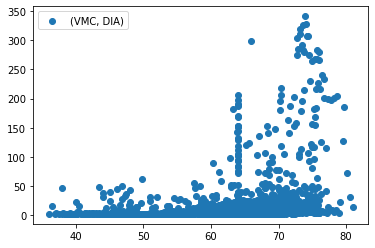

rho,  p-value
(-0.4289478256444657, 1.6701555901525747e-73)


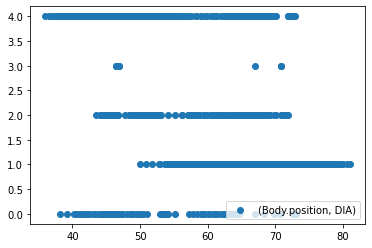

In [28]:
## Correlación
from scipy.stats import pearsonr as rho
print('rho, ', 'p-value')
print(rho(df[cond]['DIA'], df[cond]['VMC']))
plt.scatter(df[cond]['DIA'], df[cond]['VMC'], label = '(VMC, DIA)')
plt.legend()
plt.show()

print('rho, ', 'p-value')
print(rho(df[cond]['DIA'], df[cond]['Body.position']))
plt.scatter(df[cond]['DIA'], df[cond]['Body.position'], label = '(Body.position, DIA)')
plt.legend()
plt.show()

In [39]:
## Matriz de  correlacion

corr_matrix = df[cond].iloc[:,1:].corr()

In [44]:
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(10, 10))
corr_matrix.style.background_gradient(cmap='coolwarm').set_precision(1)

,HR,BR,Temperatura.piel,Temperatura.interna,Body.position,Zangle,VM,sdVM,VMC,VMCn,ENMO,AIabs,AIrel,Activity count,PAEE (KCals/kg/min),PAEE (KCals),luz,Sys,DIA,HR pressure,Mean arterial pressure
HR,1.0,0.6,-0.5,nan,-0.4,0.6,-0.2,0.7,0.6,0.6,-0.2,0.4,0.4,0.6,0.9,0.9,0.2,0.6,0.6,0.8,0.6
BR,0.6,1.0,-0.2,nan,-0.1,0.3,-0.1,0.7,0.7,0.7,-0.1,0.3,0.3,0.6,0.7,0.7,0.1,0.3,0.2,0.4,0.2
Temperatura.piel,-0.5,-0.2,1.0,nan,0.3,-0.4,0.2,-0.3,-0.3,-0.3,0.2,-0.2,-0.2,-0.2,-0.4,-0.4,-0.0,-0.3,-0.5,-0.5,-0.4
Temperatura.interna,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Body.position,-0.4,-0.1,0.3,nan,1.0,-0.7,0.3,-0.2,-0.2,-0.2,0.3,-0.3,-0.3,-0.2,-0.2,-0.2,-0.2,-0.5,-0.4,-0.5,-0.5
Zangle,0.6,0.3,-0.4,nan,-0.7,1.0,-0.5,0.4,0.4,0.4,-0.5,0.4,0.4,0.3,0.5,0.5,0.2,0.6,0.6,0.7,0.6
VM,-0.2,-0.1,0.2,nan,0.3,-0.5,1.0,-0.1,-0.1,-0.1,1.0,-0.2,-0.2,-0.1,-0.1,-0.1,-0.1,0.0,-0.1,-0.3,-0.1
sdVM,0.7,0.7,-0.3,nan,-0.2,0.4,-0.1,1.0,1.0,1.0,-0.1,0.4,0.4,1.0,0.9,0.9,0.1,0.3,0.3,0.5,0.3
VMC,0.6,0.7,-0.3,nan,-0.2,0.4,-0.1,1.0,1.0,1.0,-0.1,0.4,0.4,1.0,0.8,0.8,0.1,0.3,0.3,0.5,0.3
VMCn,0.6,0.7,-0.3,nan,-0.2,0.4,-0.1,1.0,1.0,1.0,-0.1,0.4,0.4,1.0,0.8,0.8,0.1,0.3,0.3,0.5,0.3


# PCA Module

In [118]:
import numpy as np
from sklearn.decomposition import PCA



''' 
Index(['DIA.HORA', 'HR', 'BR', 'Temperatura.piel', 'Temperatura.interna',
       'Body.position', 'Estado.de.movimiento', 'Zangle', 'VM', 'sdVM', 'VMC',
       'VMCn', 'ENMO', 'AIabs', 'AIrel', 'Activity count',
       'PAEE (KCals/kg/min)', 'PAEE (KCals)', 'luz', 'Sys', 'DIA',
       'HR pressure', 'Mean arterial pressure', 'Day', 'Dream.Status.Watch',
       'Dream.Status.subject'],
      dtype='object')

'''

def normalize(df):
      #normalized_df=(df-df.min())/(df.max()-df.min())
      normalized_df=(df-df.mean())/df.std()
      return normalized_df
def normalize_minmax(df):
      normalized_df=(df-df.min())/(df.max()-df.min())
      return normalized_df

#Parámetros externos:

#Parámetros internos:

intern_var = df[cond][['HR', 'BR']].transpose()
extern_var = df[cond][['VMC', 'Body.position']].transpose()
all_var = normalize(df[cond][['VMC', 'Body.position', 'HR', 'BR']]).transpose()
crazy_var = normalize(df[cond][['VMC', 'HR']]).transpose()
pressure_var = df[cond][['DIA','Sys']].transpose()

pca1 = PCA()
pca2 = PCA()
pca3 = PCA()
pca4 = PCA()
pca1.fit(intern_var)
pca2.fit(extern_var)
pca3.fit(all_var)
pca4.fit(crazy_var)
#pca4.fit(pressure_var)
intern_pca = pca1.components_
extern_pca = pca2.components_
all_pca = pca3.components_
crazy_pca = pca4.components_

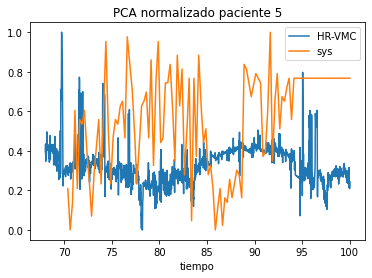

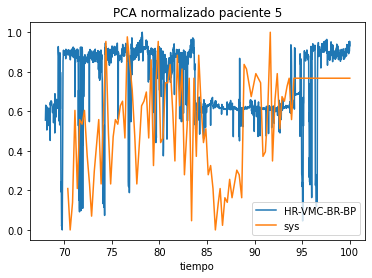

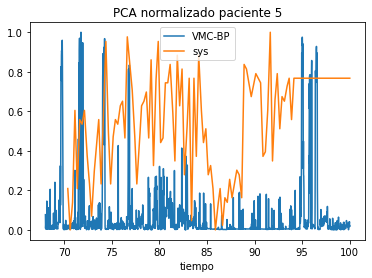

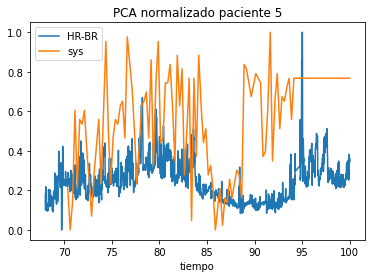

In [120]:
#plt.plot(df[cond]['DIA'])
#plt.plot(-extern_pca[0,1:])
#plt.plot(-intern_pca[0,1:])
mpld3.disable_notebook()
#plt.plot(df[cond]['DIA.HORA'].iloc[1:], normalize_minmax(-intern_pca[0,1:]))
#plt.plot(df[cond]['DIA.HORA'].iloc[1:], normalize_minmax(-extern_pca[0,1:]))
plt.plot(df[cond]['DIA.HORA'].iloc[1:], normalize_minmax(-crazy_pca[0,1:]))
plt.plot(df[cond]['DIA.HORA'].iloc[1:], normalize_minmax(df[cond]['Sys'].iloc[1:]))
plt.legend(['HR-VMC', 'sys'])
#plt.plot(normalize(df[cond]['DIA']))
plt.title(f'PCA normalizado paciente {paciente}')
plt.xlabel('tiempo')
plt.show()

plt.plot(df[cond]['DIA.HORA'].iloc[1:], normalize_minmax(-all_pca[0,1:]))
plt.plot(df[cond]['DIA.HORA'].iloc[1:], normalize_minmax(df[cond]['Sys'].iloc[1:]))
plt.legend(['HR-VMC-BR-BP', 'sys'])
#plt.plot(normalize(df[cond]['DIA']))
plt.title(f'PCA normalizado paciente {paciente}')
plt.xlabel('tiempo')
plt.show()

plt.plot(df[cond]['DIA.HORA'].iloc[1:], normalize_minmax(extern_pca[0,1:]))
plt.plot(df[cond]['DIA.HORA'].iloc[1:], normalize_minmax(df[cond]['Sys'].iloc[1:]))
plt.legend(['VMC-BP', 'sys'])
#plt.plot(normalize(df[cond]['DIA']))
plt.title(f'PCA normalizado paciente {paciente}')
plt.xlabel('tiempo')
plt.show()

plt.plot(df[cond]['DIA.HORA'].iloc[1:], normalize_minmax(intern_pca[0,1:]))
plt.plot(df[cond]['DIA.HORA'].iloc[1:], normalize_minmax(df[cond]['Sys'].iloc[1:]))
plt.legend(['HR-BR', 'sys'])
#plt.plot(normalize(df[cond]['DIA']))
plt.title(f'PCA normalizado paciente {paciente}')
plt.xlabel('tiempo')
plt.show()

# T-SNE

In [ ]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(df[['VMC', 'Body.position', 'HR', 'BR']])

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

# Análisis en el sueño

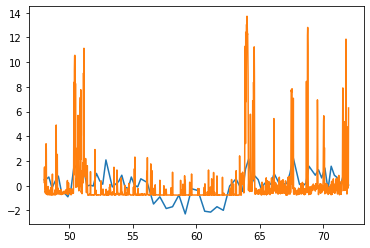

In [131]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

def mov2num(x):
    if x == 'Stationary':
        return 0
    elif x == 'MovingSlowly': 
        return 1
    elif x == 'MovingFast':
        return 2
    

plt.plot(df[cond]['DIA.HORA'], normalize(df[cond]['Sys']))
#plt.plot(df[cond]['DIA.HORA'], normalize(df[cond]['VMC'])*2)
df['Estado.de.movimiento'] = df['Estado.de.movimiento'].apply(mov2num)
#plt.plot(df[cond]['DIA.HORA'], normalize(df[cond]['Activity count']))
plt.plot(df[cond]['DIA.HORA'], normalize(df[cond]['VMC'])*2)


In [84]:
df['Estado.de.movimiento'].unique()

array(['Stationary', 'MovingSlowly', 'MovingFast'], dtype=object)